In [ ]:
#importing libraries/modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
df = pd.read_csv('bank_transactions_data_2.csv')

# CLEANING
target='TransactionAmount'
numeric=['LoginAttempts','CustomerAge', 'TransactionDuration','AccountBalance']
categorical=['TransactionType', 'Location', 'Channel', 'CustomerOccupation']
all_features=numeric+categorical+[target]

# drop the missing values
df_clean = df[all_features].dropna()

# Remove outliers in the target variable
df_clean=df_clean[df_clean[target]>0]
Q1=df_clean[target].quantile(0.25)
Q3=df_clean[target].quantile(0.75)
IQR=Q3-Q1

lower_bound=Q1 - 1.5 * IQR
upper_bound=Q3 + 1.5 * IQR
df_clean = df_clean[(df_clean[target] >= lower_bound) & (df_clean[target] <= upper_bound)]

# Create the 'is_fraud' target column based on the TransactionAmount
threshold=df_clean[target].quantile(0.9)
df_clean['is_fraud']=(df_clean[target]>=threshold).astype(int)

print(df_clean.head())

# Features (X_reg) and target (y_reg) for regression
X_reg = df_clean[numeric + categorical].copy()
y_reg = df_clean[target]

# Scaling numeric features for regression
scaler_reg = StandardScaler()
X_reg_numeric = X_reg[numeric].copy()
X_reg_scaled_numeric = scaler_reg.fit_transform(X_reg_numeric)

# Encoding categorical features for regression
encoder_reg = OneHotEncoder(drop='first', sparse_output=False)
X_reg_categorical = encoder_reg.fit_transform(X_reg[categorical])

# Combine features for regression
X_reg_final = np.hstack((X_reg_scaled_numeric, X_reg_categorical))

# Train-Test Split for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg_final, y_reg, test_size=0.2, random_state=1)



   LoginAttempts  CustomerAge  TransactionDuration  AccountBalance  \
0              1           70                   81         5112.21   
1              1           68                  141        13758.91   
2              1           19                   56         1122.35   
3              1           26                   25         8569.06   
4              1           26                  198         7429.40   

  TransactionType   Location Channel CustomerOccupation  TransactionAmount  \
0           Debit  San Diego     ATM             Doctor              14.09   
1           Debit    Houston     ATM             Doctor             376.24   
2           Debit       Mesa  Online            Student             126.29   
3           Debit    Raleigh  Online            Student             184.50   
4          Credit    Atlanta  Online            Student              13.45   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  


In [ ]:
# LINEAR REGRESSION
print('LINEAR REGRESSION')
lin_reg=LinearRegression()
lin_reg.fit(X_train_reg,y_train_reg)

y_pred_reg = lin_reg.predict(X_test_reg)
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
print("MAE:", mae_reg)

# R_sq
y_predicted_train_reg = lin_reg.predict(X_train_reg)
r2_reg = r2_score(y_train_reg, y_predicted_train_reg)
print('R² Score on Training Set:', r2_reg)

LINEAR REGRESSION
MAE: 179.36588142634173
R² Score on Training Set: 0.024894765491056736


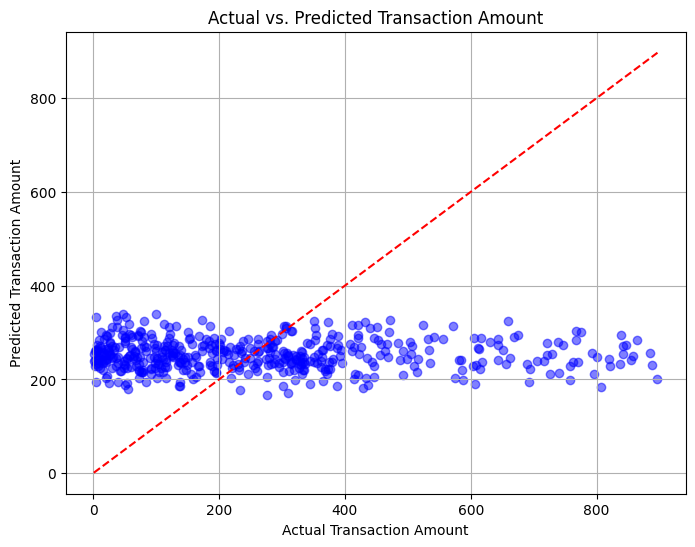

In [ ]:
# PLOTTING OF LINEAR REGRESSION (also the template for plotting scatter graphs)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5, color='blue')
plt.xlabel("Actual Transaction Amount")
plt.ylabel("Predicted Transaction Amount")
plt.title("Actual vs. Predicted Transaction Amount")
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')  # diagonal reference line
plt.grid(True)
plt.show()

In [ ]:
# RIDGE REGRESSION
print('RIDGE REGRESSION')

ridge = Ridge()
params = {'alpha': [1, 10, 100]} # Added more alpha values for demonstration
ridge_regressor = GridSearchCV(ridge, params, scoring='neg_mean_absolute_error', cv=5)
ridge_regressor.fit(X_train_reg, y_train_reg)

# Predict on test data and calculate MAE
y_pred_ridge_reg = ridge_regressor.predict(X_test_reg)
mae_ridge_reg = mean_absolute_error(y_test_reg, y_pred_ridge_reg)
print("MAE:", mae_ridge_reg)

best_mae_cv_ridge = -ridge_regressor.best_score_
print("Best alpha:", ridge_regressor.best_params_)
print("Best MAE (CV):", best_mae_cv_ridge) # Clarified this is CV MAE

# R_sq on training data
y_pred_train_ridge_reg = ridge_regressor.predict(X_train_reg)
r2_ridge_reg = r2_score(y_train_reg, y_pred_train_ridge_reg)
print("R² Score on Training Set:", r2_ridge_reg)

RIDGE REGRESSION
MAE: 178.05068601113226
Best alpha: {'alpha': 100}
Best MAE (CV): 174.57761560977033
R² Score on Training Set: 0.014666088652563802


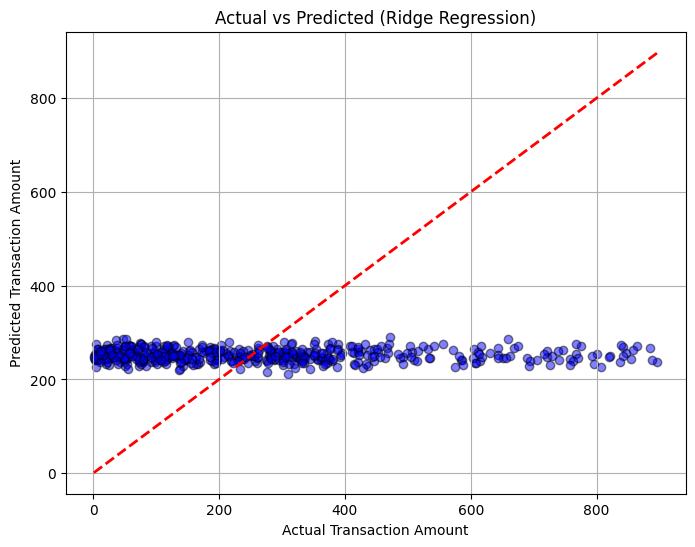

In [ ]:
# PLOTTING FOR RIDGE REGRESSION
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_ridge_reg, alpha=0.5, color='blue', edgecolors='k')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', linewidth=2)
plt.xlabel("Actual Transaction Amount")
plt.ylabel("Predicted Transaction Amount")
plt.title("Actual vs Predicted (Ridge Regression)")
plt.grid(True)
plt.show()

In [ ]:
# LASSO REGRESSION
print('LASSO REGRESSION')

lasso=Lasso()
params={'alpha':[0.01,0.1,1,10,100]}
lasso_regressor = GridSearchCV(lasso,params,scoring='neg_mean_absolute_error',cv=5) # Renamed variable to avoid confusion
lasso_regressor.fit(X_train_reg,y_train_reg)

# Predict on test data and calculate MAE
y_pred_lasso_reg = lasso_regressor.predict(X_test_reg)
mae_lasso_reg = mean_absolute_error(y_test_reg,y_pred_lasso_reg)
print("MAE:",mae_lasso_reg)

best_mae_cv_lasso = -lasso_regressor.best_score_
print("Best alpha:",lasso_regressor.best_params_)
print("Best MAE (CV):",best_mae_cv_lasso) # Clarified this is CV MAE

# R_sq on training data
y_predicted_train_lasso_reg =lasso_regressor.predict(X_train_reg)
r2_lasso_reg = r2_score(y_train_reg, y_predicted_train_lasso_reg)
print('R² Score on Training Set:', r2_lasso_reg)

LASSO REGRESSION
MAE: 177.62775185643565
Best alpha: {'alpha': 10}
Best MAE (CV): 174.20614037913003
R² Score on Training Set: 0.0


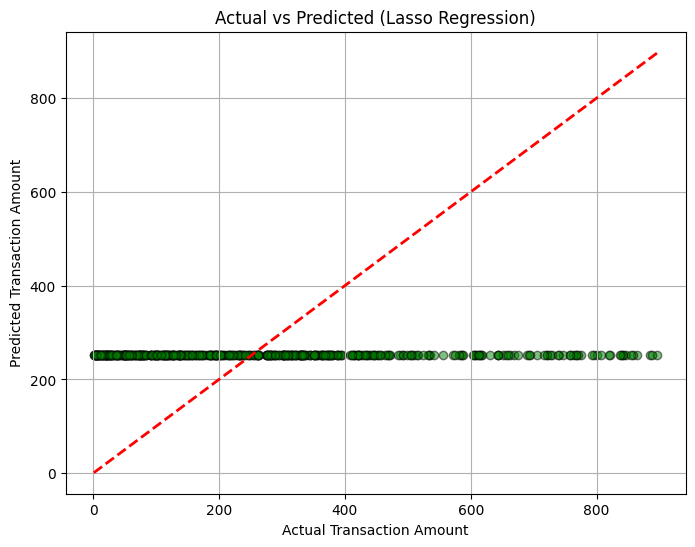

In [ ]:
# PLOTTING FOR LASSO REGRESSION
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_lasso_reg, alpha=0.5, color='green', edgecolors='k')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', linewidth=2)
plt.xlabel("Actual Transaction Amount")
plt.ylabel("Predicted Transaction Amount")
plt.title("Actual vs Predicted (Lasso Regression)")
plt.grid(True)
plt.show()

In [ ]:
#importing libraries/modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Load the dataset
df = pd.read_csv('bank_transactions_data_2.csv')

In [ ]:
# CLEANING
target='TransactionAmount'
numeric=['LoginAttempts','CustomerAge', 'TransactionDuration','AccountBalance']
categorical=['TransactionType', 'Location', 'Channel', 'CustomerOccupation']
all_features=numeric+categorical+[target]

# drop the missing values
df_clean = df[all_features].dropna()

# cleaning outliners
df_clean=df_clean[df_clean[target]>0]
Q1=df_clean[target].quantile(0.25)
Q3=df_clean[target].quantile(0.75)
IQR=Q3-Q1

lower_bound=Q1 - 1.5 * IQR
upper_bound=Q3 + 1.5 * IQR
df_clean = df_clean[(df_clean[target] >= lower_bound) & (df_clean[target] <= upper_bound)]

# as transaction amount is continuous it continuos data, so we fake the model by creating an extra column of [isfraud] which stores the values of trasaction amount greater then 90% of the spending done by all users
threshold=df_clean[target].quantile(0.9)
df_clean['is_fraud']=(df_clean[target]>=threshold).astype(int)

print(df_clean.head())

   LoginAttempts  CustomerAge  TransactionDuration  AccountBalance  \
0              1           70                   81         5112.21   
1              1           68                  141        13758.91   
2              1           19                   56         1122.35   
3              1           26                   25         8569.06   
4              1           26                  198         7429.40   

  TransactionType   Location Channel CustomerOccupation  TransactionAmount  \
0           Debit  San Diego     ATM             Doctor              14.09   
1           Debit    Houston     ATM             Doctor             376.24   
2           Debit       Mesa  Online            Student             126.29   
3           Debit    Raleigh  Online            Student             184.50   
4          Credit    Atlanta  Online            Student              13.45   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  


/tmp/ipython-input-10-3669290375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['is_fraud']=(df_clean[target]>=threshold).astype(int)


In [ ]:
# Split into features (X) and target (y)

X = df_clean[numeric + categorical]
y=df_clean['is_fraud']

# Check value counts in the target variable before splitting
print("Value counts in y before split:")
print(y.value_counts())

Value counts in y before split:
is_fraud
0    2159
1     240
Name: count, dtype: int64


In [ ]:
# Scaling - Apply StandardScaler only to the numeric columns within the X DataFrame
scaler = StandardScaler()
# We need to apply the scaler to the numeric columns of X and keep the categorical ones separate for now
# Create a copy to avoid SettingWithCopyWarning
X_numeric = X[numeric].copy() # we copy the cleaned dataset into another dataset variable to prevent modification to the orignal dataset
X_scaled_numeric = scaler.fit_transform(X_numeric)


In [ ]:
# Encoder-used to encode categorical features (converting to int64)
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical = encoder.fit_transform(X[categorical])

In [ ]:
# Combine all the processed features (numerical and categorical)
X_final = np.hstack((X_scaled_numeric, X_categorical))

In [ ]:
# TTS

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=1,stratify=y)

# Check value counts in the training set after splitting
print("\nValue counts in y_train after split:")
print(y_train.value_counts())


Value counts in y_train after split:
is_fraud
0    1727
1     192
Name: count, dtype: int64


In [ ]:
# LOGISTIC REGRESSION
print('--------------------')
print("LOGISTIC REGRESSION")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log=LogisticRegression(
    penalty='l2',     #shows that ridge regularisation is being used
    C=1.0,            #controls how strict the regularisation is. more the value more desciplined the model is and less the value more freedom that model has
    solver='lbfgs',   #this is the algorithm used to find the best weights (or coefficients) for the model
    max_iter=100,     #this sets the maximum number of iterations the solver can take while trying to converge i.e., find the best solution
    random_state=42,
    class_weight='balanced')

log.fit(X_train,y_train)

y_pred=log.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print('--------------------')

--------------------
LOGISTIC REGRESSION
Accuracy: 0.5416666666666666

Confusion Matrix:
 [[236 196]
 [ 24  24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.55      0.68       432
           1       0.11      0.50      0.18        48

    accuracy                           0.54       480
   macro avg       0.51      0.52      0.43       480
weighted avg       0.83      0.54      0.63       480

--------------------


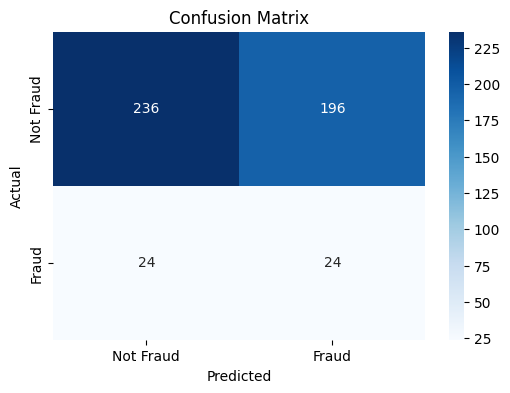

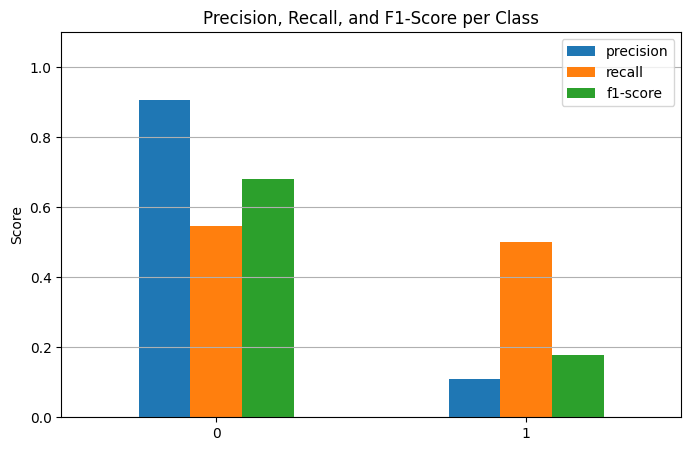

In [ ]:
# DATA VISUALISATION

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))    # 6 inch wide 4 inch tall
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
#here...
# cm is the confusion matrix
# annot=True is putting the number inside a box
# fmt='d' formats numbers into integers
# cmap='Reds' sets colour theme to red
# xticklabels and yticklabels-->gives custom names to the x and y axis ticks ("Not Fraud", "Fraud")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Bar Plot (also the template for data visualisation of a dataset working on classification model)
report = classification_report(y_test, y_pred, output_dict=True) #output_dict=True returns the report as a dictionary, not a string which allows us to manipulate it like data
report_df = pd.DataFrame(report).transpose() # converts the classification report dictionary into a DataFrame for easier plotting
report_df[['precision', 'recall', 'f1-score']].iloc[:2].plot(kind='bar', figsize=(8, 5))
plt.title('Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.show()
